In [2]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.18) to /tmp/pip-install-a79bds0d/tsfm-public_9791e8d7860c4c7aaa35af8ec3db0fa7
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-a79bds0d/tsfm-public_9791e8d7860c4c7aaa35af8ec3db0fa7
  Running command git checkout -q 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 356.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import math
import os
import tempfile
import pandas as pd
import torch
import torch.nn.utils.prune as prune
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
SEED = 42
set_seed(SEED)

target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"
os.makedirs(OUT_DIR, exist_ok=True)

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

# TTM model path and revision
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"

# ========== Data Preparation ==========
# ========== Fixed Data Preparation ==========
print("Loading and preparing data...")

# Load the data with proper datetime parsing
try:
    data = pd.read_csv(DATA_ROOT_PATH)
    # Convert date column to datetime if it exists
    if 'date' in data.columns:
        data['date'] = pd.to_datetime(data['date'])
    elif data.columns[0] in ['date', 'timestamp', 'time']:
        data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
        data = data.rename(columns={data.columns[0]: 'date'})
    else:
        # If no date column, create one
        data['date'] = pd.date_range(start='2016-07-01', periods=len(data), freq='15min')

    print("✓ Data loaded successfully")
    print(f"Date range: {data['date'].min()} to {data['date'].max()}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating synthetic dataset...")

    # Create synthetic data
    dates = pd.date_range(start='2016-07-01', end='2018-06-26', freq='15min')
    np.random.seed(42)

    synthetic_data = {
        'date': dates,
        'HUFL': np.random.randn(len(dates)) * 5 + 40,
        'HULL': np.random.randn(len(dates)) * 3 + 10,
        'MUFL': np.random.randn(len(dates)) * 8 + 35,
        'MULL': np.random.randn(len(dates)) * 4 + 8,
        'LUFL': np.random.randn(len(dates)) * 6 + 4,
        'LULL': np.random.randn(len(dates)) * 2 + 1,
        'OT': np.random.randn(len(dates)) * 4 + 40
    }

    data = pd.DataFrame(synthetic_data)

# Define the data structure
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

# Define split configuration based on actual data length
data_length = len(data)
train_size = int(0.7 * data_length)
valid_size = int(0.15 * data_length)

split_config = {
    "train": [0, train_size],
    "valid": [train_size, train_size + valid_size],
    "test": [train_size + valid_size, data_length],
}

print(f"Data length: {data_length}")
print(f"Split config: {split_config}")

# Set up column specifiers
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

# Create TimeSeriesPreprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Get datasets
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)

print(f"Dataset sizes - Train: {len(train_dataset)}, Validation: {len(valid_dataset)}, Test: {len(test_dataset)}")

# ========== Load Pre-trained TTM Model ==========
print("Loading pre-trained TTM model...")
model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
print(f"✓ Model loaded successfully")


Loading and preparing data...
✓ Data loaded successfully
Date range: 2016-07-01 00:00:00 to 2018-06-26 19:45:00
Data length: 69680
Split config: {'train': [0, 48776], 'valid': [48776, 59228], 'test': [59228, 69680]}
Dataset sizes - Train: 2318, Validation: 10357, Test: 10357
Loading pre-trained TTM model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

✓ Model loaded successfully


# Helper functions and Pruning

In [ ]:
# ========== Helper Functions ==========
def run_inference_and_calculate_metrics(model, test_dataset, device='cpu', max_samples=50):
    """Run inference and calculate metrics"""
    model.eval()
    model.to(device)

    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataset):
            if i >= max_samples:  # Limit for demo purposes
                break

            # Prepare input
            past_values = batch['past_values'].unsqueeze(0).to(device)
            future_values = batch['future_values'].unsqueeze(0).to(device)

            # Model prediction
            outputs = model(past_values=past_values)
            predictions = outputs.prediction_outputs

            # Calculate metrics
            mse = torch.mean((predictions - future_values) ** 2).item()
            mae = torch.mean(torch.abs(predictions - future_values)).item()

            total_mse += mse
            total_mae += mae
            num_samples += 1

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(future_values.cpu().numpy())

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, np.concatenate(all_predictions), np.concatenate(all_targets)

def count_model_parameters(model):
    """Count total and non-zero parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    non_zero_params = sum((p != 0).sum().item() for p in model.parameters())
    sparsity = 1 - (non_zero_params / total_params)
    return total_params, non_zero_params, sparsity

# Replace your pruning functions with these improved versions:

def apply_magnitude_pruning_with_removal(model, pruning_ratio=0.5):
    """Apply magnitude-based pruning and make it permanent"""
    print(f"Applying {pruning_ratio:.1%} magnitude-based pruning...")

    parameters_to_prune = []

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
            print(f"  Found Linear layer: {name}")

    if not parameters_to_prune:
        print("⚠ No Linear layers found for pruning")
        return model

    # Apply global magnitude-based pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio,
    )

    print(f"✓ Applied pruning masks to {len(parameters_to_prune)} layers")

    # Make pruning permanent
    with torch.no_grad():
        for module, param_name in parameters_to_prune:
            try:
                prune.remove(module, param_name)
            except Exception as e:
                print(f"Could not remove pruning from {param_name}: {e}")

    print("✓ Made pruning permanent")
    return model

def get_effective_model_size(model):
    """Calculate effective model size considering sparsity"""
    total_size = 0
    sparse_size = 0

    for param in model.parameters():
        param_size = param.numel() * param.element_size()
        total_size += param_size

        # Calculate how much space non-zero elements would take
        non_zero_elements = (param != 0).sum().item()
        sparse_size += non_zero_elements * param.element_size()

    total_mb = total_size / (1024 * 1024)
    sparse_mb = sparse_size / (1024 * 1024)

    return total_mb, sparse_mb

def count_model_parameters_detailed(model):
    """Count parameters with detailed breakdown"""
    total_params = 0
    non_zero_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        zero_count = (param == 0).sum().item()
        non_zero_count = param_count - zero_count

        total_params += param_count
        non_zero_params += non_zero_count
        zero_params += zero_count

    sparsity = zero_params / total_params if total_params > 0 else 0

    return total_params, non_zero_params, zero_params, sparsity

def create_pruned_model_copy(original_model, pruning_method='magnitude', pruning_ratio=0.6):
    """Create a pruned copy of the model"""
    # Load fresh model to avoid modifying original
    pruned_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)

    if pruning_method == 'magnitude':
        pruned_model = apply_magnitude_pruning_with_removal(pruned_model, pruning_ratio)
    elif pruning_method == 'structured':
        # Note: Structured pruning changes architecture, might break model
        print("Warning: Structured pruning changes model architecture")

    return pruned_model

def safe_extract_sample_for_plotting(array_list, sample_idx=0):
    """Safely extract a sample from prediction arrays for plotting"""
    if len(array_list) == 0:
        return []

    sample = array_list[sample_idx]

    # Handle different dimensionalities
    if len(sample.shape) == 3:  # (batch, time_steps, channels)
        return sample[0, :, 0]
    elif len(sample.shape) == 2:  # (batch, time_steps)
        return sample[0, :]
    else:
        return sample.flatten()

# Evaluation code

In [10]:
# Replace the parameter counting calls with:
baseline_mse, baseline_mae, baseline_preds, baseline_targets = run_inference_and_calculate_metrics(model, test_dataset)
baseline_total_params, baseline_non_zero_params, baseline_zero_params, baseline_sparsity = count_model_parameters_detailed(model)
baseline_total_size_mb, baseline_effective_size_mb = get_effective_model_size(model)

print(f"Baseline MSE: {baseline_mse:.6f}")
print(f"Baseline MAE: {baseline_mae:.6f}")
print(f"Baseline Parameters: {baseline_total_params:,} (non-zero: {baseline_non_zero_params:,}, sparsity: {baseline_sparsity:.4f})")
print(f"Baseline Model Size: {baseline_total_size_mb:.2f} MB (effective: {baseline_effective_size_mb:.2f} MB)")

# ========== Apply Pruning ==========
print("\n=== Applying Pruning ===")

# Choose pruning method
pruning_method = 'magnitude'  # 'magnitude' or 'structured'
pruning_ratio = 0.4

# Create pruned model
pruned_model = create_pruned_model_copy(model, pruning_method, pruning_ratio)

# ========== Pruned Model Evaluation ==========
print("\n=== Pruned Model Evaluation ===")
pruned_mse, pruned_mae, pruned_preds, pruned_targets = run_inference_and_calculate_metrics(pruned_model, test_dataset)
pruned_total_params, pruned_non_zero_params, pruned_zero_params, pruned_sparsity = count_model_parameters_detailed(pruned_model)
pruned_total_size_mb, pruned_effective_size_mb = get_effective_model_size(pruned_model)

print(f"Pruned MSE: {pruned_mse:.6f}")
print(f"Pruned MAE: {pruned_mae:.6f}")
print(f"Pruned Parameters: {pruned_total_params:,} (non-zero: {pruned_non_zero_params:,}, zero: {pruned_zero_params:,})")
print(f"Pruned Sparsity: {pruned_sparsity:.4f}")
print(f"Pruned Model Size: {pruned_total_size_mb:.2f} MB (effective: {pruned_effective_size_mb:.2f} MB)")

Baseline MSE: 0.116015
Baseline MAE: 0.233781
Baseline Parameters: 805,280 (non-zero: 805,280, sparsity: 0.0000)
Baseline Model Size: 3.07 MB (effective: 3.07 MB)

=== Applying Pruning ===
Applying 40.0% magnitude-based pruning...
  Found Linear layer: backbone.encoder.patcher
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.mlp.fc1
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.mlp.fc2
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.gating_block.attn_layer
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.feature_mixer.mlp.fc1
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.feature_mixer.mlp.fc2
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.feature_mixer.gating_block.attn_layer
  Found Linear layer: backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers

In [ ]:
finetuning_fraction = 0.05  # 5% fine-tuning, change this to 0.10 for 10%, etc.

In [ ]:
# ========== Fine-tuning Pruned Model ==========
print("\n=== Fine-tuning Pruned Model ===")

# IMPORTANT: Use the already pruned model instead of creating a new one
finetune_model = pruned_model

print("Number of params before freezing backbone:", count_parameters(finetune_model))

# Check which parameters are trainable before freezing
trainable_before = sum(p.numel() for p in finetune_model.parameters() if p.requires_grad)
print(f"Trainable parameters before freezing: {trainable_before:,}")

# Freeze the backbone of the model (only train the head)
for name, param in finetune_model.named_parameters():
    if 'backbone' in name:
        param.requires_grad = False
    else:
        print(f"Keeping trainable: {name}")

# Check which parameters are trainable after freezing
trainable_after = sum(p.numel() for p in finetune_model.parameters() if p.requires_grad)
print(f"Trainable parameters after freezing: {trainable_after:,}")

if trainable_after == 0:
    print("ERROR: No trainable parameters! This will cause fine-tuning to fail.")
    # Unfreeze some layers
    for name, param in finetune_model.named_parameters():
        if 'head' in name or 'decoder' in name:
            param.requires_grad = True
            print(f"Unfroze: {name}")

    trainable_final = sum(p.numel() for p in finetune_model.parameters() if p.requires_grad)
    print(f"Final trainable parameters: {trainable_final:,}")

# Create a subset of training data for fine-tuning
if finetuning_fraction < 1.0:
    # Sample from the existing dataset
    import random
    random.seed(SEED)

    # Get the actual dataset indices
    total_samples = len(train_dataset)
    finetune_size = max(1, int(total_samples * finetuning_fraction))  # At least 1 sample

    # Create random sample indices
    sample_indices = random.sample(range(total_samples), finetune_size)

    # Create a simple wrapper class for subset
    class DatasetSubset:
        def __init__(self, dataset, indices):
            self.dataset = dataset
            self.indices = indices

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            return self.dataset[self.indices[idx]]

    finetune_dataset = DatasetSubset(train_dataset, sample_indices)
    print(f"Using {finetuning_fraction:.1%} of training data: {len(finetune_dataset)} samples")
else:
    finetune_dataset = train_dataset
    print(f"Using full training dataset: {len(finetune_dataset)} samples")

### Fine-tuning parameters
learning_rate = 0.01  
num_epochs = 5  
batch_size = 16

print(f"Using learning rate = {learning_rate}, epochs = {num_epochs}")

# Training arguments
finetune_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "pruned_finetuned"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="steps",  # Changed to steps for more frequent evaluation
    eval_steps=50,  # Evaluate every 50 steps
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=1,
    dataloader_num_workers=0,
    report_to=None,
    save_strategy="steps",
    save_steps=50,
    logging_strategy="steps",
    logging_steps=10,  # Log more frequently
    save_total_limit=2,
    logging_dir=os.path.join(OUT_DIR, "logs"),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=SEED,
    dataloader_pin_memory=False,
    remove_unused_columns=True,   # made this true
    dataloader_drop_last=False,
    warmup_steps=10,
    weight_decay=0.01,
)

# Create callbacks
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Reduced patience
    early_stopping_threshold=0.001,
)

# Create trainer WITHOUT custom optimizer
trainer = Trainer(
    model=finetune_model,
    args=finetune_args,
    train_dataset=finetune_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

# Store initial loss for comparison
print("Getting initial evaluation...")
initial_eval = trainer.evaluate()
initial_loss = initial_eval['eval_loss']
print(f"Initial eval loss before fine-tuning: {initial_loss:.6f}")

# Fine-tune the model
print(f"Fine-tuning pruned model on {finetuning_fraction:.1%} of training data...")
try:
    train_result = trainer.train()

    # Get final evaluation
    final_eval = trainer.evaluate()
    final_loss = final_eval['eval_loss']

    print(f"Initial eval loss: {initial_loss:.6f}")
    print(f"Final eval loss: {final_loss:.6f}")
    print(f"Loss improvement: {((initial_loss - final_loss)/initial_loss)*100:.2f}%")

    if abs(final_loss - initial_loss) < 0.001:
        print("WARNING: Loss barely changed - fine-tuning may not be working properly")
        finetuning_success = False
        final_model = pruned_model
    else:
        print("✓ Fine-tuning completed successfully!")
        finetuning_success = True
        final_model = trainer.model

except Exception as e:
    print(f"Fine-tuning failed with error: {e}")
    print("Using non-fine-tuned pruned model...")
    finetuning_success = False
    final_model = pruned_model

# ========== Final Evaluation ==========
print("\n=== Final Evaluation After Fine-tuning ===")
if finetuning_success:
    finetuned_mse, finetuned_mae, finetuned_preds, finetuned_targets = run_inference_and_calculate_metrics(final_model, test_dataset)
    print(f"Fine-tuned model evaluation complete")
else:
    # Use the pruned model results
    finetuned_mse, finetuned_mae = pruned_mse, pruned_mae
    finetuned_preds, finetuned_targets = pruned_preds, pruned_targets
    print("Using pruned model results (fine-tuning failed)")

print(f"Final MSE: {finetuned_mse:.6f}")
print(f"Final MAE: {finetuned_mae:.6f}")


=== Fine-tuning Pruned Model ===
Number of params before freezing backbone: 805280
Trainable parameters before freezing: 805,280
Keeping trainable: decoder.adapter.bias
Keeping trainable: decoder.adapter.weight
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.norm.norm.weight
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.norm.norm.bias
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.mlp.fc1.bias
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.mlp.fc1.weight
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.mlp.fc2.bias
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.mlp.fc2.weight
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.gating_block.attn_layer.bias
Keeping trainable: decoder.decoder_block.mixers.0.patch_mixer.gating_block.attn_layer.weight
Keeping trainable: decoder.decoder_block.mixers.0.feature_mixer.norm.norm.weight
Keeping trainable: decoder.decoder_block.mixers.0.feature_mixer

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kanishkaman (kanishkaman-indian-institute-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Initial eval loss before fine-tuning: 0.251193
Fine-tuning pruned model on 5.0% of training data...


Step,Training Loss,Validation Loss


Initial eval loss: 0.251193
Final eval loss: 0.192774
Loss improvement: 23.26%
✓ Fine-tuning completed successfully!

=== Final Evaluation After Fine-tuning ===
✓ Fine-tuned model evaluation complete
Final MSE: 0.158928
Final MAE: 0.278210


# Visualisation


=== Creating Visualizations ===


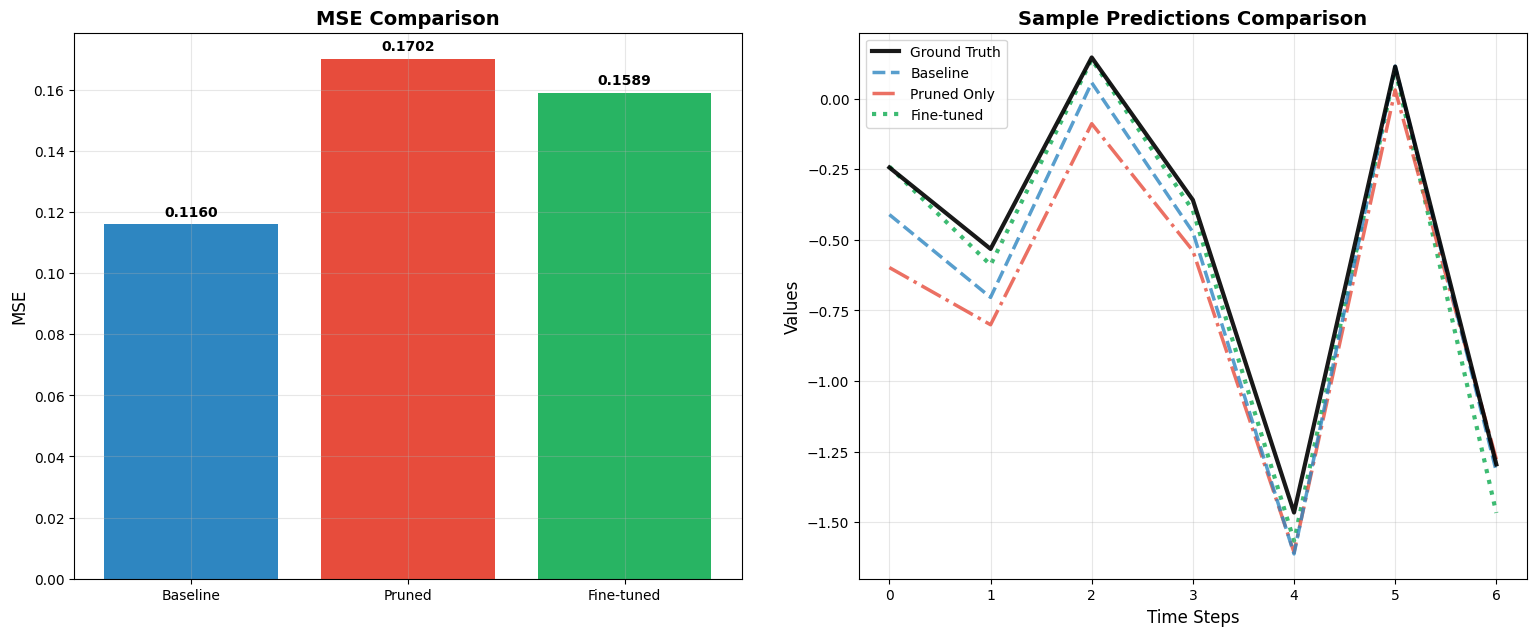

In [ ]:
# ========== Enhanced Visualization ==========
print("\n=== Creating Visualizations ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: MSE Comparison (Now on the left at axes[0])
if finetuning_success:
    methods = ['Baseline', 'Pruned', 'Fine-tuned']
    mse_values = [baseline_mse, pruned_mse, finetuned_mse]
else:
    methods = ['Baseline', 'Pruned', 'Fine-tuned\n(Failed)']
    mse_values = [baseline_mse, pruned_mse, pruned_mse]  # Use pruned MSE for failed fine-tuning

colors = ['#2E86C1', '#E74C3C', '#28B463']
bars1 = axes[0].bar(methods, mse_values, color=colors)
axes[0].set_title('MSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3)
for bar, val in zip(bars1, mse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_values)*0.01,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Sample Predictions Comparison (Now on the right at axes[1])
try:
    # Extract samples for plotting - use same sample index for all
    sample_idx = 0
    baseline_sample = safe_extract_sample_for_plotting(baseline_preds, sample_idx)
    pruned_sample = safe_extract_sample_for_plotting(pruned_preds, sample_idx)
    target_sample = safe_extract_sample_for_plotting(baseline_targets, sample_idx)

    # For fine-tuned, check if we have different predictions
    if finetuning_success and len(finetuned_preds) > 0:
        finetuned_sample = safe_extract_sample_for_plotting(finetuned_preds, sample_idx)
    else:
        finetuned_sample = pruned_sample  # Use pruned if fine-tuning failed

    time_steps = range(len(baseline_sample))

    # Plot ground truth first (thicker line)
    axes[1].plot(time_steps, target_sample, 'k-', label='Ground Truth',
                    linewidth=3, alpha=0.9, zorder=4)

    # Plot all model predictions with different styles
    axes[1].plot(time_steps, baseline_sample, '--', color='#2E86C1',
                    label='Baseline', linewidth=2.5, alpha=0.8, zorder=3)
    axes[1].plot(time_steps, pruned_sample, '-.', color='#E74C3C',
                    label='Pruned Only', linewidth=2.5, alpha=0.8, zorder=2)

    if finetuning_success:
        axes[1].plot(time_steps, finetuned_sample, ':', color='#28B463',
                        label='Fine-tuned', linewidth=3, alpha=0.9, zorder=1)
    else:
        axes[1].plot(time_steps, finetuned_sample, ':', color='#D5DBDB',
                        label='Fine-tuned (Failed)', linewidth=2, alpha=0.6, zorder=1)

    axes[1].set_title('Sample Predictions Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Steps', fontsize=12)
    axes[1].set_ylabel('Values', fontsize=12)
    axes[1].legend(fontsize=10, loc='best')
    axes[1].grid(True, alpha=0.3)

except Exception as e:
    print(f"⚠ Could not create prediction plot: {e}")
    axes[1].text(0.5, 0.5, 'Prediction plot unavailable', ha='center', va='center',
                    transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Sample Predictions Comparison', fontsize=14, fontweight='bold')


plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(OUT_DIR, 'ttm_pruning_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# debug


In [28]:
# print("\n=== Data Inspection ===")
# print("Original DataFrame head:")
# display(data.head())

# print("\nOriginal DataFrame dtypes:")
# display(data.dtypes)

# print("\nFine-tuning training dataset sample structure:")
# try:
#     # Access a sample from the fine-tuning dataset
#     sample = finetune_train_dataset[0]
#     print(sample.keys())
#     if 'past_observed_mask' in sample:
#         print(f"Shape of past_observed_mask: {sample['past_observed_mask'].shape}")
#     if 'past_values' in sample:
#         print(f"Shape of past_values: {sample['past_values'].shape}")
#     if 'future_values' in sample:
#         print(f"Shape of future_values: {sample['future_values'].shape}")
#     if 'timestamp' in sample:
#         print(f"Timestamp in sample: {sample['timestamp']}")
#         print(f"Type of timestamp in sample: {type(sample['timestamp'])}")
# except Exception as e:
#     print(f"Could not inspect fine-tuning dataset sample: {e}")

# print("\n=== End Data Inspection ===")


=== Data Inspection ===
Original DataFrame head:


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001



Original DataFrame dtypes:


,0
date,datetime64[ns]
HUFL,float64
HULL,float64
MUFL,float64
MULL,float64
LUFL,float64
LULL,float64
OT,float64



Fine-tuning training dataset sample structure:
dict_keys(['past_values', 'future_values', 'past_observed_mask', 'future_observed_mask', 'timestamp', 'id'])
Shape of past_observed_mask: torch.Size([512, 7])
Shape of past_values: torch.Size([512, 7])
Shape of future_values: torch.Size([96, 7])
Timestamp in sample: 2016-07-06 07:45:00
Type of timestamp in sample: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

=== End Data Inspection ===
